# ***Naive Bayes***

## ***Write your id numbers and names here***

1.   Name - Leor Ariel Rose, ID - 208373365

## ***1. Classifying Digits***
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model), in contrast to the Multivariate Logistic Regression (a discriminative model) we used before.

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathematical analysis clarity, and for matching expected API, each image is flatten to create a 1D array with 784 elements.

### ***Loading the MNIST dataset***
Load the MNIST data set. The digits dataset is one of the datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```
to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the performance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
```

11501568/11490434 [==============================] - 0s 0us/step




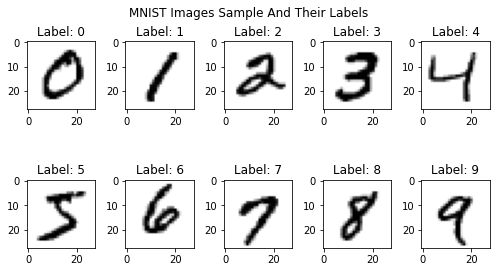



MNIST train images shape (60000, 784)
MNIST train labels shape (60000,)
MNIST test images shape (10000, 784)
MNIST test labels shape (10000,)


In [1]:
# import all necessary packages
import string
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.datasets import fetch_20newsgroups
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import check_X_y
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csr import csr_matrix
from typing import Union, List

# make sure plots appear in the notebook
%matplotlib inline

# set the random seed for numpy
np.random.seed(seed=42)

# get mnist dataset - already divided by 1/7 to test and 6/7 to train
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# create a combined dataset
images = np.concatenate([X_train, X_test], axis=0)
labels = np.concatenate([y_train, y_test], axis=0)

# separate plot
print("\n")

# create sub plot for each digit
fig, ax = plt.subplots(2,5, figsize=(7,4))
# loop over each subplot to add its digit
for i, ax in enumerate(ax.flatten()):
    # find index for image with the corresponding digit
    img_idx = np.argwhere(labels == i)[0]
    # get the image and reshape to 28X28
    img = np.reshape(images[img_idx], (28, 28))
    # plot digit image
    ax.imshow(img, cmap="gray_r")
    # add digit label
    ax.set_title(f"Label: {i}")
# add title to the plot
fig.suptitle("MNIST Images Sample And Their Labels")
# adjust the padding between and around subplots
fig.tight_layout()
# show plot
plt.show()

# reshape every image to a vector of 784 features
X_train_reshaped = X_train.reshape(X_train.shape[0], 784)
X_test_reshaped = X_test.reshape(X_test.shape[0], 784)

print("\n")
print(f"MNIST train images shape {X_train_reshaped.shape}")
print(f"MNIST train labels shape {y_train.shape}")
print(f"MNIST test images shape {X_test_reshaped.shape}")
print(f"MNIST test labels shape {y_test.shape}")

In the plot we can see a sample of every digit we have in our dataset and its corresponding label. Images have the shape of 28X28.

We also see we have 60000 images and labels for training (6/7 of the dataset) and 10000 images and labels for testing (1/7 of the dataset). Images were reshaped to a vector of 784 features.

### ***Bernoulli Naive Bayes***
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixel is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accordingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


#### ***Question 1***
Write the classification rule based on this Naive Bayes model. 
How would you estimate each of the parameters of the model based on the training data? 
Describe in text (preferably math notations) the classification rule, and explain.

**Bonus:** Think of edge cases which may affect your estimator in an undesired way.

#### ***Answer 1***

**The classification rule** based on this Naive Bayes model is the following:

$$
\hat{y} = 
\mathrm{argmax}_{j \in [0,9]} \pi_j * P_j(x)= 
\mathrm{argmax}_{j \in [0,9]} \> Pr(y=j) * \prod_{i=0}^{784} Pr(x_i \mid  y=j)
.$$

for the class prior probability:
$$
\Pr(y=j) = \dfrac{N_j}{N} = \text{The fraction of training examples with class j}
$$

for the likelihood:
$$
\Pr(x_i \mid  y=j) = \Pr(i \mid  y=j) * x_i + (1 - \Pr(i \mid  y=j)) * (1-x_i)
$$

$$
\text{so if } x_i = 1 \text{ then }
\Pr(x_i \mid  y=j) = \Pr(i \mid  y=j) = \dfrac{N_{1j}}{N_j}
$$

$$
\text{and if } x_i = 0 \text{ then }
\Pr(x_i \mid  y=j) = (1 - \Pr(i \mid  y=j)) = (1-\dfrac{N_{1j}}{N_j})
$$

$$
\dfrac{N_{1j}}{N_j} = \text{The fraction of examples with value 1 and class j within feature i.}
$$

**Edge cases** which may affect our estimator in an undesired way:
- Zero count problem: during training, we may encounter a feature that shows up in one class, but not in the other. To fix this we will apply laplace correction.
- underflow: multiplying all these tiny probabilities to find the product can cause underflow. To fix this we will apply log transformation.

#### ***Question 2***
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as calculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


#### ***Answer 2***


1 - mean image of each class and a generated sample of each class:



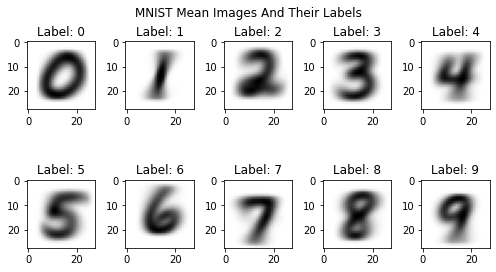

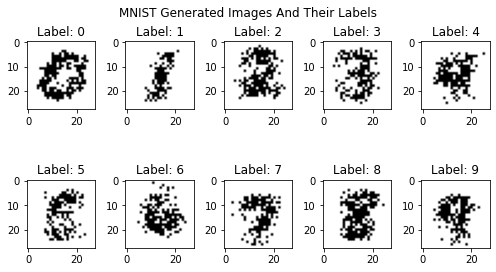


2 - confusion matrix of the trained classifier as calculated on the test data and calculate the total accuracy:



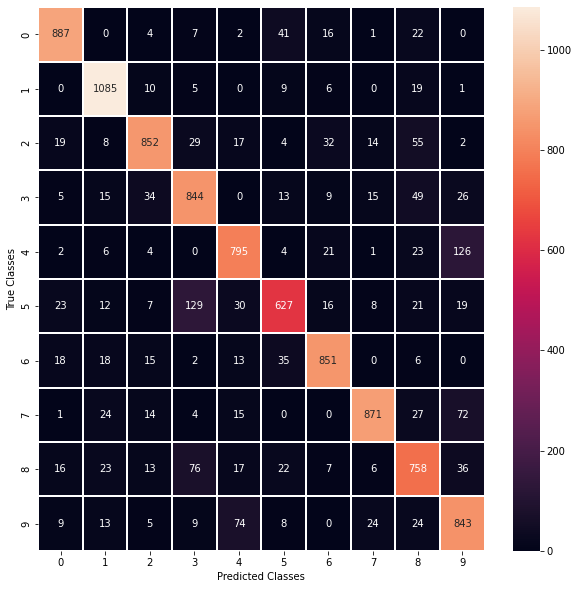


Total accuracy:0.8413


In [2]:
# create a bernoulli naive bayes classifier
clf = BernoulliNB(binarize=0)
# fit classifier on training set
clf.fit(X_train_reshaped, y_train)
# predict on test set
y_pred = clf.predict(X_test_reshaped)

# print text of question
print(("\n1 - mean image of each class"), 
      ("and a generated sample of each class:\n"))

# create sub plot for each digit
fig, ax = plt.subplots(2,5, figsize=(7,4))
# loop over each subplot to add its digit
for i, ax in enumerate(ax.flatten()):
    # get mean vector representation of corresponding digit
    vec_mean = np.exp(clf.feature_log_prob_[i]) * 255
    # reshape vector to 28X28 image
    img = vec_mean.reshape((28, 28))
    # plot digit image
    ax.imshow(img, cmap="gray_r")
    # add digit label
    ax.set_title(f"Label: {i}")
# add title to the plot
fig.suptitle("MNIST Mean Images And Their Labels")
# adjust the padding between and around subplots
fig.tight_layout()
# show plot
plt.show()

# separate plots
print("\n")

# calculate the probabilities from the naive bayes log probabilities
probability = np.exp(clf.feature_log_prob_)
# create sub plot for each digit
fig, ax = plt.subplots(2,5, figsize=(7,4))
# loop over each subplot to add its digit
for i, ax in enumerate(ax.flatten()):
    # get a sample from bernoulli distribution with probabilities p
    vec_generated = np.random.binomial(
        1,np.exp(clf.feature_log_prob_[i]), 784)
    # reshape vector to 28X28 image
    img = vec_generated.reshape((28, 28))
    # plot digit image
    ax.imshow(img, cmap="gray_r")
    # add digit label
    ax.set_title(f"Label: {i}")
# add title to the plot
fig.suptitle("MNIST Generated Images And Their Labels")
# adjust the padding between and around subplots
fig.tight_layout()
# show plot
plt.show()

# print text of question
print(("\n2 - confusion matrix of the trained classifier"), 
      ("as calculated on the test data and calculate the total accuracy:\n"))

# plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, y_pred), linewidths=1, annot=True,
            fmt='g')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()

# print the total accuracy
print(f"\nTotal accuracy:{accuracy_score(y_test, y_pred)}")

1. In the first plot we can see 10 images, each image is the mean of each class and its class. In the second plot we can see 10 images, each image is the generated image of each class from the naive bayes probabilities and its class. Images have the shape of 28X28.

2. In the third plot we can see the confusion matrix of the trained classifier, the y-axis are the true classes and the x-axis are the predicted classes. The number in each box represents the number of samples our model classified an image with the y-axis class to the x-axis class. Our model total accuracy is 0.8413. If we inspect where our model got confused we can see the most in error is in the following: 4-9, 5-3, 7-9, 8-3, 9-4. Our model got confused with digits which don't surprise us because of their similarity. In order to fix this we can try to enhance these images or try to use a different classifier capable of separating between these classes.

3. The way to find the optimal threshold of the binarization part will be to do a grid search (hyper parameter tuning of the binarization threshold), meaning we will go over each possible value [0-255] or a group of values we believe will be the best and test each one and see how our model performs.


## 2. Classifying Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare it to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.

### You task
Implement the barebone class provided: `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.

Then follow next analysis guidelines using the implemented class for train and test classifier:
* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* use `sklearn.pipeline.make_pipeline` to chain the vectorizer and model.
* note: limit the vocabulary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* compare to `TfidfVectorizer` preprocessing (you can use the built in model for doing the analysis)
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).


In [3]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    """
    Naive bayes classifier based on BaseEstimator and ClassifierMixin
    from scikit-learn.
    """
    def fit(self, x: Union[np.ndarray, csr_matrix],
            y: np.ndarray) -> 'NaiveBayes':
        """
        Method to fit model on data

        Args:
            x: np.ndarray, sparse matrix of shape (n_samples, n_features)
            y: np.ndarray of shape (n_samples,) or (n_samples, n_targets)

        Returns:
            NaiveBayes: the self classifier object.
        """
        # check that x and y have correct shape
        x_, y_ = check_X_y(x, y, accept_sparse=True)
        
        # if x is not np.ndarray convert it to array
        if type(x) is not np.ndarray:
            x_ = x.toarray()
        
        # binarize labels in a one-vs-all fashion and store the 
        # classes seen during fit
        lb = LabelBinarizer()
        y_ = lb.fit_transform(y)
        self.classes_ = lb.classes_
        
        # count features by getting dot product of binarize labels 
        # transpose and frequency table and count classes
        self.feature_count_ = np.dot(y_.T, x_)
        self.class_count_ = y_.sum(axis=0)
        
        # return the classifier
        return self
    
    def predict_log_proba(
        self,x: Union[np.ndarray, csr_matrix]) -> np.ndarray:
        """
        Method to predict the log probabilities

        Args:
            x: np.ndarray, sparse matrix of shape (n_samples, n_features)

        Returns:
            np.ndarray: the the log probabilities
        """
        # if x is not np.ndarray convert it to array
        if type(x) is not np.ndarray:
            x= x.toarray() 
        
        # adding 1 to the features count - correction
        smoothed_features = self.feature_count_ + 1
        
        # calculating the number of words in a given class
        smoothed_class = smoothed_features.sum(axis = 1).reshape(-1,1)
        
        # features log probability is log(number of time a word i accord with 
        # class j) - log(number of words in class j)
        feature_log_probs = np.log(smoothed_features) - np.log(smoothed_class)
        
        # class probability is log(number of samples with class j) - 
        # log(number of samples)
        class_log_priors = (np.log(self.class_count_) - 
                            np.log(self.class_count_.sum()))
        
        # calculate the log probability for each class for each sample
        return np.dot(x, feature_log_probs.T) + class_log_priors

    def predict(self, x: Union[np.ndarray, csr_matrix]) -> np.ndarray:
        """
        Method to predict log class

        Args:
            x: np.ndarray, sparse matrix of shape (n_samples, n_features)

        Returns:
            numpy.ndarray: the classes
        """
        # if x is not np.ndarray convert it to array
        if type(x) is not np.ndarray:
            x= x.toarray() 

        # Check if fit had been called
        check_is_fitted(self)
        
        # Input validation
        x = check_array(x)

        # get the log probabilities
        probabilities = self.predict_log_proba(x)

        # get the prediction that has the the max probability for each sample
        predictions = self.classes_[np.argmax(probabilities, axis=1)]

        return predictions


# get the 20 newsgroups training data
twenty_train = fetch_20newsgroups(subset='train', shuffle=True,
                                  random_state=42,
                                  remove=("headers", "footers", "quotes"))

# get the 20 newsgroups test data
twenty_test = fetch_20newsgroups(subset='test', shuffle=True,
                                 random_state=42,
                                 remove=("headers", "footers", "quotes"))

# create pipeline with our model and CountVectorizer
text_clf_1 = Pipeline([
    ('vect', CountVectorizer(stop_words="english", max_features=1000)),
    ('clf', NaiveBayes()),
])

# create pipeline with built in model and CountVectorizer
text_clf_2 = Pipeline([
    ('vect', CountVectorizer(stop_words="english", max_features=1000)),
    ('clf', MultinomialNB()),
])

# create pipeline with our model model and TfidfVectorizer
text_clf_3 = Pipeline([
    ('vect', TfidfVectorizer(stop_words="english", max_features=1000)),
    ('clf', NaiveBayes()),
])

# create pipeline with built in model and TfidfVectorizer
text_clf_4 = Pipeline([
    ('vect', TfidfVectorizer(stop_words="english", max_features=1000)),
    ('clf', MultinomialNB()),
])

# train each pipeline
text_clf_1.fit(twenty_train.data, twenty_train.target)
text_clf_2.fit(twenty_train.data, twenty_train.target)
text_clf_3.fit(twenty_train.data, twenty_train.target)
text_clf_4.fit(twenty_train.data, twenty_train.target)


# get predictions from each pipeline
y_pred_1 = text_clf_1.predict(twenty_test.data)
y_pred_2 = text_clf_2.predict(twenty_test.data)
y_pred_3 = text_clf_3.predict(twenty_test.data)
y_pred_4 = text_clf_4.predict(twenty_test.data)


# print accuracy from each pipeline
print("Accuracy of our model and CountVectorizer:", 
      f"{accuracy_score(twenty_test.target, y_pred_1)}")
print("Accuracy of built in model and CountVectorizer:", 
      f"{accuracy_score(twenty_test.target, y_pred_2)}")
print("Accuracy of our model and TfidfVectorizer:", 
      f"{accuracy_score(twenty_test.target, y_pred_3)}")
print("Accuracy of built in model and TfidfVectorizer:", 
      f"{accuracy_score(twenty_test.target, y_pred_4)}")

Accuracy of our model and CountVectorizer: 0.4638874137015401
Accuracy of built in model and CountVectorizer: 0.4638874137015401
Accuracy of our model and TfidfVectorizer: 0.5262878385554965
Accuracy of built in model and TfidfVectorizer: 0.5262878385554965


We can see that our model performs the same as the built in model and that tf-idf gives better results than a bag of words (CountVectorizer).

Next let's plot the learning curve:

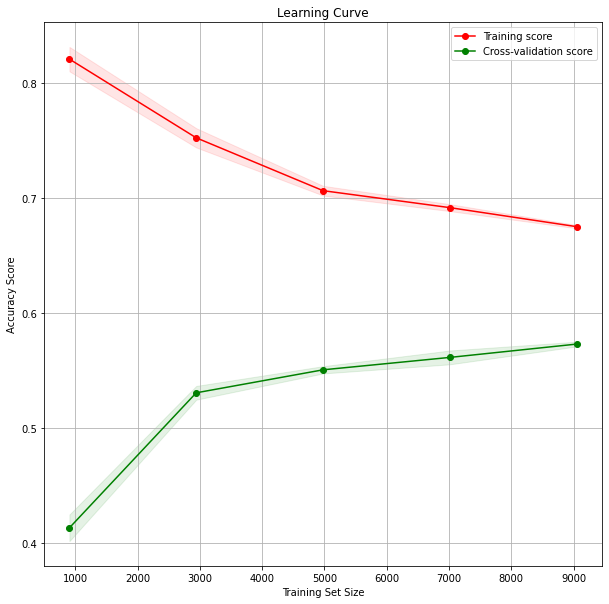

In [4]:
# create pipeline with built in model and TfidfVectorizer
estimator = Pipeline([
    ('vect', TfidfVectorizer(stop_words="english", max_features=1000)),
    ('clf', MultinomialNB()),
])

# get scores on training and validation for each size
train_sizes, train_scores, validation_scores  = learning_curve(
    estimator, twenty_train.data, twenty_train.target, cv=5)

# plot learning curve - from scikit-learn documentation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)
plt.figure(figsize=(10, 10))
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.legend(loc="best")
plt.show()

From the learning curve we can see our model has High bias and Low variance.

Lastly, let's optimize performance in respect to vectorizer hyper parameters on the built in model (**note** - this can take 1-2 minutes):

In [5]:
# create pipeline with built in model and TfidfVectorizer
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words="english")),
    ('clf', MultinomialNB()),
])

# parameters to find best combination
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 1000, 5000),
}

# create a grid search
grid_search = GridSearchCV(pipeline, parameters)

# train grid search
grid_search.fit(twenty_train.data, twenty_train.target)

# print best parameters
print(f"Best parameters: {grid_search.best_params_}")

# create pipeline with built in model and TfidfVectorizer
# and best parameters
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words="english", max_df=0.5,
                             max_features=None)),
    ('clf', MultinomialNB()),
])

# train pipeline on all training set
pipeline.fit(twenty_train.data, twenty_train.target)

# predict on test set
y_pred = pipeline.predict(twenty_test.data)

# print accuracy to show optimization
print("Accuracy of optimized pipeline:", 
      f"{accuracy_score(twenty_test.target, y_pred)}")

Best parameters: {'vect__max_df': 0.5, 'vect__max_features': None}
Accuracy of optimized pipeline: 0.6779075942644716


As we can see we managed to improve (optimize) our model accuracy from 0.526 to 0.677 by changing vectorizer hyper parameters.


### Bonus I (5 points)
#### Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words.

In [6]:
def print_txt(txt:str, hot:List, cold:List) -> None:
    """
    Function to print the text, coloring hot and cold words with colors

    Args:
        txt: the text to print color
        hot: list of words to color with hot
        cold: list of words to color with cold
    """
    cold_color='\x1b[41;37m{}\x1b[0m'
    hot_color='\x1b[42;37m{}\x1b[0m'
    def color(token: str):
        """
        Function to colo a token hot and cold words colors

        Args:
            token: the token to color.
        """
        lower = str(token).lower()
        lower = lower.replace('\t','').replace('\n','')
        lower = "".join([i for i in lower if i not in string.punctuation])
        if (lower in hot) and (lower in cold):
            return token
        elif lower in hot:
            return hot_color.format(token)
        elif lower in cold:
            return cold_color.format(token)
        else:
            return token
    colored_txt = ""
    for line in txt.split("\n"):
        line_colored_txt = " ".join([color(token) for token in line.split()])
        colored_txt += (line_colored_txt + "\n")
    print(colored_txt)

print_txt('This word support the first class but this the other', 
          ['word'], ['other'])

This word support the first class but this the other



In [7]:
def calc_p_c_given_xi(model) -> np.ndarray:
    """
    Function to calculate posterior of term x_i 

    Args:
        model: scikit-learn NB model.
    """
    # get the prior probability of class
    p_c = np.exp(model.class_log_prior_)
    # get the likelihood
    p_xi_given_c = np.exp(model.feature_log_prob_)
    # multiply prior probability of class with likelihood
    p_c_given_xi = p_c.reshape(-1,1) * p_xi_given_c
    # get the prior probability of predictor
    # P(xi|c) = P(xi and c) \ P(c)
    # P(xi|c) * P(c) = P(xi and c)
    # sum(P(xi and c)) for each c = p_xi
    p_xi = p_c_given_xi.sum(axis=0)
    # return posterior of term x_i 
    return p_c_given_xi / p_xi


# create a vectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                             max_df=0.5, max_features=None)

# create pipeline with built in model and TfidfVectorizer
# and best parameters
pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', MultinomialNB()),
])

# train pipeline on all training set
pipeline.fit(twenty_train.data, twenty_train.target)

# predict on test set
y_pred = pipeline.predict(twenty_test.data)

# get indexes of sample wrongly classified
wrong_indexes = np.where(y_pred != twenty_test.target)[0]

# get posterior
p_c_given_xi = calc_p_c_given_xi(pipeline['clf'])

# create a mapping of index to word from vectorizer
index_2_word={index:word for word, index in vectorizer.vocabulary_.items()}

# loop over 10 wrongly classified sentences
for i in wrong_indexes[:10]:
    # get the wrong classified sentence
    sentence = twenty_test.data[i]

    # get real class
    y = twenty_test.target[i]

    # get predicted class
    y_hat = y_pred[i]

    # get indexes of word that are in the sentence
    words_indexes = vectorizer.transform([sentence]).toarray()[0].nonzero()[0]

    # create list to store each word and its importance score
    words_scores_pred = []
    words_scores_real = []

    # loop over word indexes and store its importance score for the real
    # and predicted class
    for j in words_indexes:
        words_scores_pred.append((index_2_word[j], p_c_given_xi[y_hat,j]))
        words_scores_real.append((index_2_word[j], p_c_given_xi[y, j]))
    
    # sort words by importance score
    words_scores_pred = sorted(words_scores_pred,
                               key=lambda tup: tup[1], reverse=True)
    words_scores_real = sorted(words_scores_real,
                               key=lambda tup: tup[1], reverse=True)
    
    # print the text with colors representing there importance
    # red - supports the false class, in case of mistake, green
    # - supports the true class. we use only max 10 words and 
    # the words need to have more than 0.05 importance
    print(f"Sentence - {i}")
    print(f"Real Class (green) - {twenty_train.target_names[y]}")
    print(f"Predicted Class (red) - {twenty_train.target_names[y_hat]}\n")
    print_txt(sentence, [i[0] for i in words_scores_pred[:10] if i[1]>0.1],
              [i[0] for i in words_scores_real[:10] if i[1]>0.1])
    print("--------------------------------------------------------\n")

Sentence - 1
Real Class (green) - comp.windows.x
Predicted Class (red) - comp.graphics

I'm not familiar at all with the format of these "X-Face:" thingies, but
after seeing them in some folks' headers, I've *got* to *see* them (and
maybe make one of my own)!

I've got "dpg-view" on my Linux box (which displays "uncompressed X-Faces")
and I've managed to compile [un]compface too... but now that I'm *looking*
for them, I can't seem to find any X-Face:'s in anyones news headers! :-(

Could you, would you, please send me your "X-Face:" header?

I *know* I'll probably get a little swamped, but I can handle it.

...I hope.

--------------------------------------------------------

Sentence - 2
Real Class (green) - alt.atheism
Predicted Class (red) - soc.religion.christian


In a word, yes.


--------------------------------------------------------

Sentence - 4
Real Class (green) - talk.religion.misc
Predicted Class (red) - alt.atheism


I've just spent two solid months arguing that no such

### Bonus II (5 points)
#### How can you correct the analyzed error?

To read more about model interpretation, see the blogpost below and the tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

From looking at the 10 sentences we printed and their most important features i think we can correct the analyzed error and improve accuracy by applying the following:

1. hierarchical classification - As we can see some of the error is due to wrongly classifying samples in the same parent group for example sentence 16 is classified into 'comp.os.ms-windows.misc' instead of 'comp.graphics'. We can reduce error by first creating a classifier to classify the sample into parent group ('comp') and then classify inside this group ('os.ms-windows.misc', 'graphics').
2. custom stop words - The stop words we used in our preprocess are very general and don't take into consideration our data set for example the word 'thanks' repeats a lot and it doesn't really contribute. We need to create a more custom stop word removal.